<a href="https://colab.research.google.com/github/SapirGabay/ML_Project/blob/main/ML_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **From part 1**

Comprehensive Data Cleaning and Feature Engineering Function

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import urllib.request


top_30_features = [
    'num_hashtags', 'negative_word_count', 'season_winter', 'is_post_in_positive_season',
    'positive_word_count', 'has_multiple_hashtags', 'hashtags_3_plus', 'is_high_post_frequency',
    'posts_per_year_avg', 'previous_posts_count', 'season_summer', 'season_spring',
    'hashtags_2', 'checkmark_gold', 'checkmark_grey', 'checkmark_none',
    'has_profile_picture', 'time_bucket_Night', 'likes_per_follower', 'is_daytime_post',
    'time_bucket_Morning', 'is_younger_user', 'word_count', 'followers',
    'posts_retweets', 'is_short_post', 'age', 'checkmark_blue',
    'post_hour', 'age_<20'
]



def clean_and_prepare_data(df_raw, positive_words, negative_words, trained_scaler, is_train=True):
    # --- Replace '?' with NA ---
    df = df_raw.replace('?', pd.NA).copy()

    # --- Fill numeric columns with median ---
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    # --- Fill categorical columns with mode ---
    categorical_cols = ['type', 'checkmark', 'timezone']
    for col in categorical_cols:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

    # --- Clean version for feature generation ---
    df_clean = df.copy()

    # --- Convert datetime columns ---
    df_clean['birthday'] = pd.to_datetime(df_clean['birthday'], errors='coerce', dayfirst=True)
    df_clean['account_creation_date'] = pd.to_datetime(df_clean['account_creation_date'], errors='coerce', dayfirst=True)
    df_clean['post_datetime'] = pd.to_datetime(df_clean['post_datetime'], errors='coerce', dayfirst=True)

    # --- Age and account duration ---
    df_clean['age'] = pd.to_datetime('today').year - df_clean['birthday'].dt.year
    df_clean['account_age'] = pd.to_datetime('today').year - df_clean['account_creation_date'].dt.year

    # --- Convert key columns to numeric ---
    for col in ['post_likes', 'followers', 'previous_posts_count', 'posts_retweets', 'account_age']:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # --- Binary features ---
    df_clean['has_profile_picture'] = df_clean['profile_picture'].notna().astype(int)
    df_clean['has_embedded_content'] = df_clean['embedded_content_url'].notna().astype(int)

    # --- Content type ---
    def detect_content_type(url):
        if pd.isna(url):
            return 'none'
        url = str(url).lower()
        if any(ext in url for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            return 'image'
        elif any(ext in url for ext in ['.mp4', '.mov', '.avi']):
            return 'video'
        return 'other'

    df_clean['content_type'] = df_clean['embedded_content_url'].apply(detect_content_type)

    # --- Time-related features ---
    df_clean['post_hour'] = df_clean['post_datetime'].dt.hour
    df_clean['post_month'] = df_clean['post_datetime'].dt.month
    df_clean['is_weekend'] = df_clean['post_datetime'].dt.weekday >= 5
    df_clean['is_weekend'] = df_clean['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

    def bucket_time(hour):
        if pd.isna(hour):
            return 'Unknown'
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        return 'Night'

    df_clean['post_time_bucket'] = df_clean['post_hour'].apply(bucket_time)

    # --- Season encoding ---
    df_clean['season'] = df_clean['post_month'].map({
        12: 'winter', 1: 'winter', 2: 'winter',
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'fall', 10: 'fall', 11: 'fall'
    })
    season_dummies = pd.get_dummies(df_clean['season'], prefix='season')
    df_clean = pd.concat([df_clean, season_dummies], axis=1)

    # --- One-hot encode checkmark ---
    checkmark_dummies = pd.get_dummies(df_clean['checkmark'], prefix='checkmark')
    df_clean = pd.concat([df_clean, checkmark_dummies], axis=1)

    # --- One-hot encode time bucket ---
    time_dummies = pd.get_dummies(df_clean['post_time_bucket'], prefix='time_bucket')
    df_clean = pd.concat([df_clean, time_dummies], axis=1)

    # --- Text and engagement ---
    df_clean['word_count'] = df_clean['text'].apply(lambda x: len(str(x).split()))
    df_clean['num_hashtags'] = df_clean['text'].apply(lambda x: str(x).count('#'))
    df_clean['engagement_score'] = df_clean['post_likes'] + df_clean['posts_retweets']

    df_clean['likes_per_follower'] = np.where(
        df_clean['followers'] > 0,
        df_clean['post_likes'] / df_clean['followers'],
        np.nan
    )

    df_clean['posts_per_year_avg'] = np.where(
        (df_clean['account_age'].isna()) | (df_clean['account_age'] == 0),
        df_clean['previous_posts_count'],
        df_clean['previous_posts_count'] / df_clean['account_age']
    )

    def count_sentiment_words(text, word_set):
        words = str(text).lower().split()
        return sum(word in word_set for word in words)

    df_clean['positive_word_count'] = df_clean['text'].apply(lambda x: count_sentiment_words(x, positive_words))
    df_clean['negative_word_count'] = df_clean['text'].apply(lambda x: count_sentiment_words(x, negative_words))

    # --- Derived binary features ---
    df_clean['is_daytime_post'] = df_clean['post_hour'].apply(lambda x: 1 if 5 <= x < 17 else 0)
    df_clean['is_post_in_positive_season'] = df_clean['post_month'].apply(lambda x: 1 if 2 <= x <= 10 else 0)
    df_clean['is_short_post'] = df_clean['word_count'].apply(lambda x: 1 if x < 20 else 0)
    df_clean['is_high_post_frequency'] = df_clean['posts_per_year_avg'].apply(lambda x: 1 if x > 10 else 0)
    df_clean['has_multiple_hashtags'] = df_clean['num_hashtags'].apply(lambda x: 1 if x >= 3 else 0)
    df_clean['is_younger_user'] = df_clean['age'].apply(lambda x: 1 if x < 30 else 0)
    df_clean['age_<20'] = df_clean['age'].apply(lambda x: 1 if x < 20 else 0)
    df_clean['hashtags_2'] = df_clean['num_hashtags'].apply(lambda x: 1 if x == 2 else 0)
    df_clean['hashtags_3_plus'] = df_clean['num_hashtags'].apply(lambda x: 1 if x >= 3 else 0)

    # --- Drop unnecessary columns ---
    df_clean.drop(columns=[
        'post_datetime', 'embedded_content_url', 'username',
        'account_creation_date', 'email', 'birthday', 'profile_picture',
        'season', 'post_time_bucket', 'checkmark'
    ], inplace=True, errors='ignore')

    # --- Copy before scaling ---
    df_features = df_clean.copy()

    # --- Ensure all scaler features exist and scale them ---
    for col in trained_scaler.feature_names_in_:
        if col not in df_features.columns:
            df_features[col] = 0

    df_features[trained_scaler.feature_names_in_] = trained_scaler.transform(
        df_features[trained_scaler.feature_names_in_]
    )

    # --- Final selection based on top_30_features ---
    missing = [col for col in top_30_features if col not in df_features.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    df_selected = df_features[top_30_features + ['id']].copy()
    if 'text' in df_features.columns:
        df_selected['text'] = df_features['text']


    if is_train and 'sentiment' in df_raw.columns:
        df_selected['sentiment'] = df_raw['sentiment'].values

    print("Final columns:", df_selected.columns.tolist())
    print("Missing values:", df_selected.isnull().sum().sum())

    return df_selected


def prepare_test_data_only(df_test_raw, positive_words, negative_words, trained_scaler):
    return clean_and_prepare_data(
        df_raw=df_test_raw,
        positive_words=positive_words,
        negative_words=negative_words,
        trained_scaler=trained_scaler,
        is_train=False
    )

import requests
import joblib






Wrapper Function for Data Loading, Sentiment Words Integration, and Full Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import requests
import joblib

# Define wrapper function for loading and preparing data
def load_and_prepare_for_model(csv_path, scaler_path, positive_words_url, negative_words_url, is_train=True, top_features=None):

    # Load raw dataset
    df_raw = pd.read_csv(csv_path)

    # Load sentiment word lists
    pos_text = requests.get(positive_words_url).text
    positive_words = set([line.strip() for line in pos_text.splitlines() if line.strip() and not line.startswith(';')])

    neg_text = requests.get(negative_words_url).text
    negative_words = set([line.strip() for line in neg_text.splitlines() if line.strip() and not line.startswith(';')])

    # Load pre-fitted scaler
    if scaler_path.startswith('http'):
        trained_scaler = joblib.load(urllib.request.urlopen(scaler_path))
    else:
        trained_scaler = joblib.load(scaler_path)

    # --- Drop rows with missing or unexpected sentiment values ---
    if is_train and 'sentiment' in df_raw.columns:
        df_raw = df_raw[df_raw['sentiment'].isin(['positive', 'negative'])].copy()

    # Apply full pipeline
    df_prepared = clean_and_prepare_data(
        df_raw=df_raw,
        positive_words=positive_words,
        negative_words=negative_words,
        trained_scaler=trained_scaler,
        is_train=is_train
    )

    # Define final feature set if not passed
    if top_features is None:
        top_features = [col for col in df_prepared.columns if col != 'sentiment']

    # Select features and optionally target
    X = df_prepared[top_features].copy()
    y = df_prepared['sentiment'].copy() if is_train and 'sentiment' in df_prepared.columns else None


    return X, y, df_prepared


In [ ]:

# CSV
url_csv = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/test.csv"
df = pd.read_csv(url_csv)
test_original_df = df.copy()

# Positive words
url_pos = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/positive-words.txt"
positive_words = set([
    line.strip() for line in requests.get(url_pos).text.splitlines()
    if line.strip() and not line.startswith(';')
])

# Negative words
url_neg = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/negative-words.txt"
negative_words = set([
    line.strip() for line in requests.get(url_neg).text.splitlines()
    if line.strip() and not line.startswith(';')
])

X_train, y_train, df_train_full = load_and_prepare_for_model(
    csv_path="https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/sentiment.csv",
    scaler_path="https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/scaler.pkl",
    positive_words_url="https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/positive-words.txt",
    negative_words_url="https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/negative-words.txt",
    is_train=True,
    top_features=top_30_features
)

# === Create Separate Copies of the Preprocessed Dataset for Each Model ===
# So each model works on its own DataFrame to avoid any interference
df_dt_selected  = df_train_full.copy()   # For Decision Tree
df_mlp_selected = df_train_full.copy()   # For MLP
df_svm_selected = df_train_full.copy()   # For SVM





Final columns: ['num_hashtags', 'negative_word_count', 'season_winter', 'is_post_in_positive_season', 'positive_word_count', 'has_multiple_hashtags', 'hashtags_3_plus', 'is_high_post_frequency', 'posts_per_year_avg', 'previous_posts_count', 'season_summer', 'season_spring', 'hashtags_2', 'checkmark_gold', 'checkmark_grey', 'checkmark_none', 'has_profile_picture', 'time_bucket_Night', 'likes_per_follower', 'is_daytime_post', 'time_bucket_Morning', 'is_younger_user', 'word_count', 'followers', 'posts_retweets', 'is_short_post', 'age', 'checkmark_blue', 'post_hour', 'age_<20', 'id', 'text', 'sentiment']
Missing values: 4122


### **Part 2**

## 0.
Train-Validation Split and Cross-Validation Setup for Model Training

In [ ]:
#  Imports
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

#  Data Preparation
X = X_train.copy()
y = y_train.copy()


le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Encoded labels:", np.unique(y_encoded))

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

#  Grid Search with Cross Validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

Encoded labels: [0 1]


# 1.	Model Training

## 1.1 Decision Tree

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits
Best Hyperparameters:
{'criterion': 'entropy', 'max_depth': np.int64(7), 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
AUC on Validation Set: 0.9763


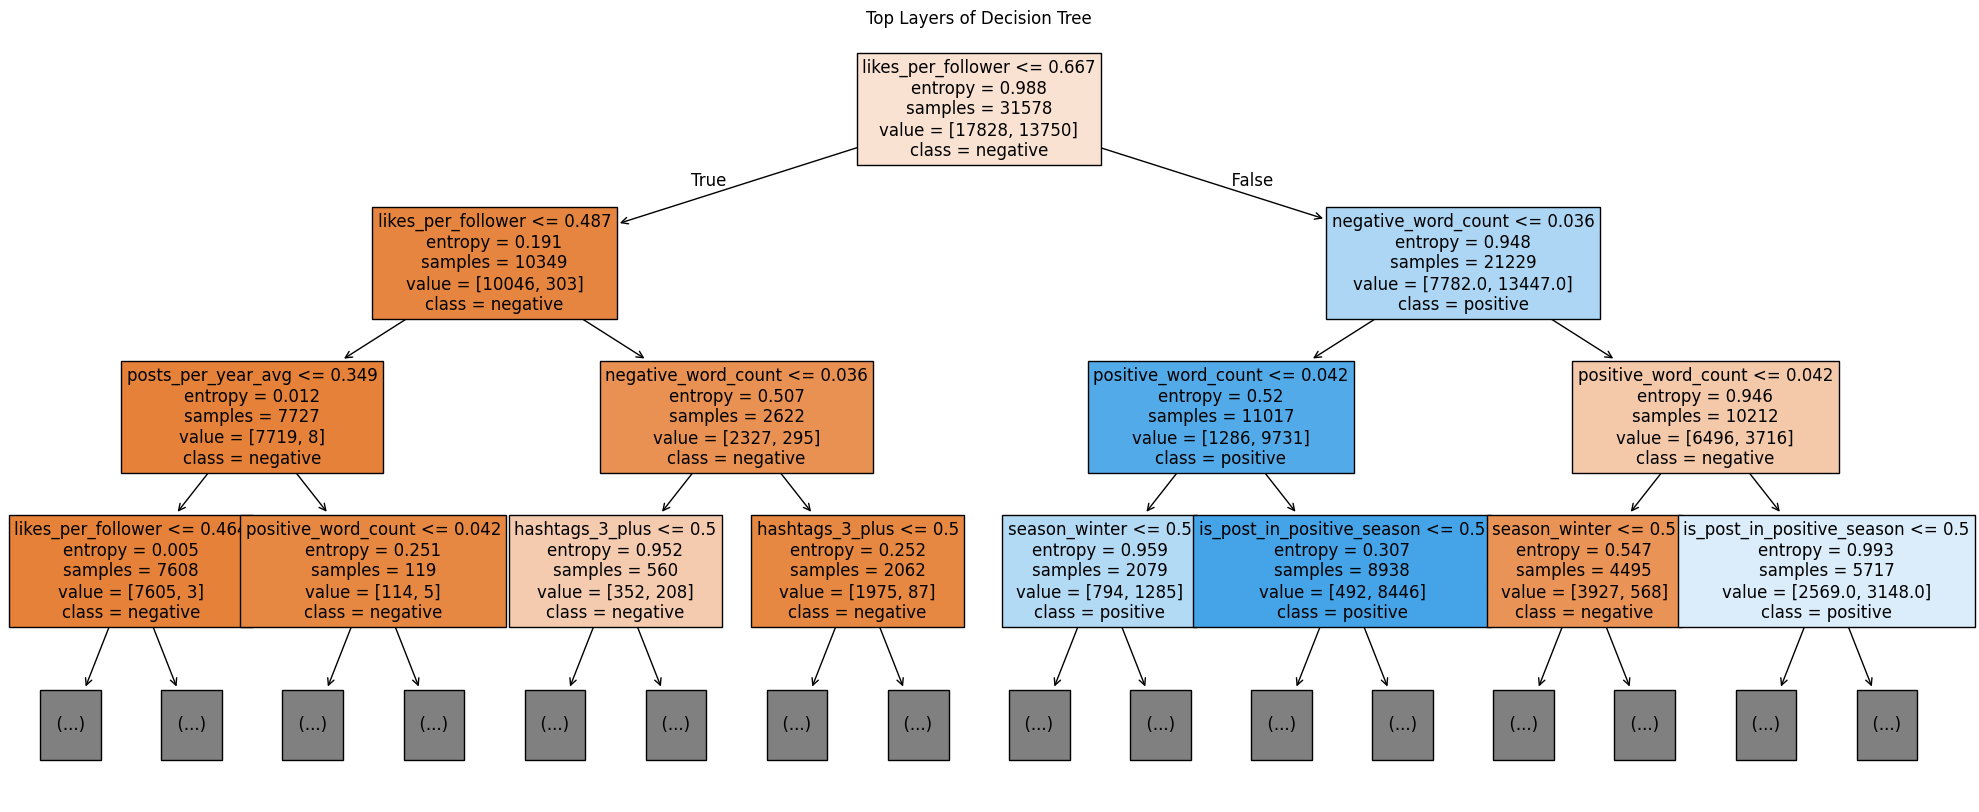

<ipython-input-5-2421620823>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted_dt.values[:10], y=importances_sorted_dt.index[:10], palette="Blues_d")


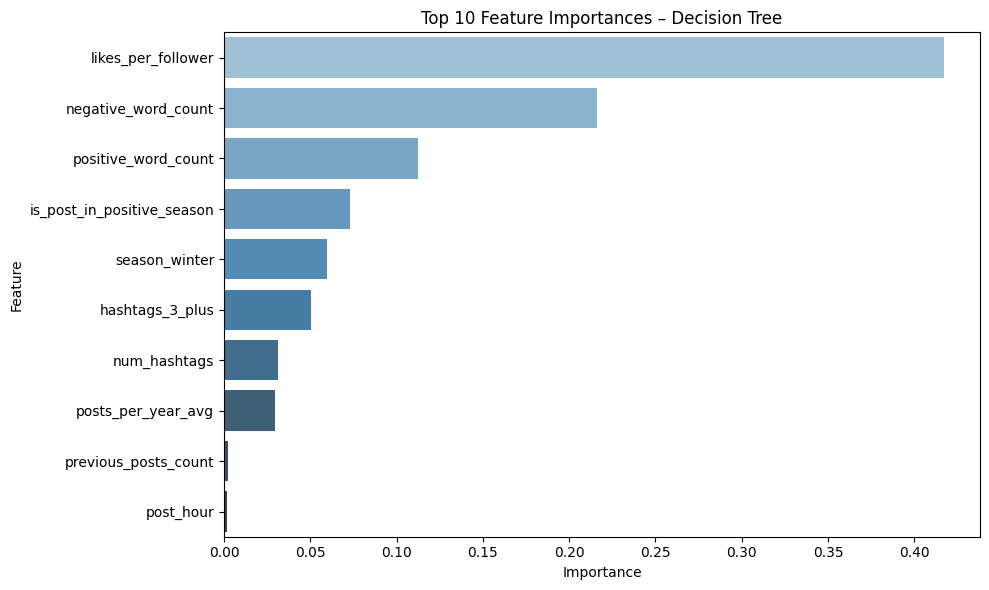

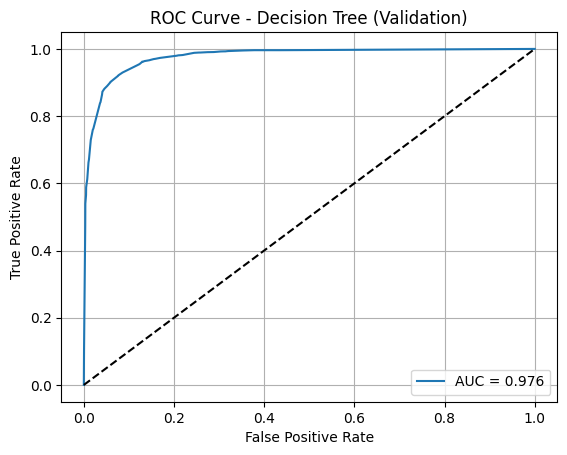

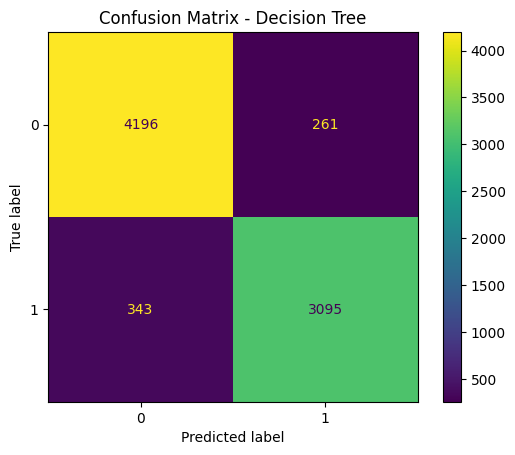

AUC on Training Set (balanced tree): 0.9808
AUC on Validation Set (balanced tree): 0.9763


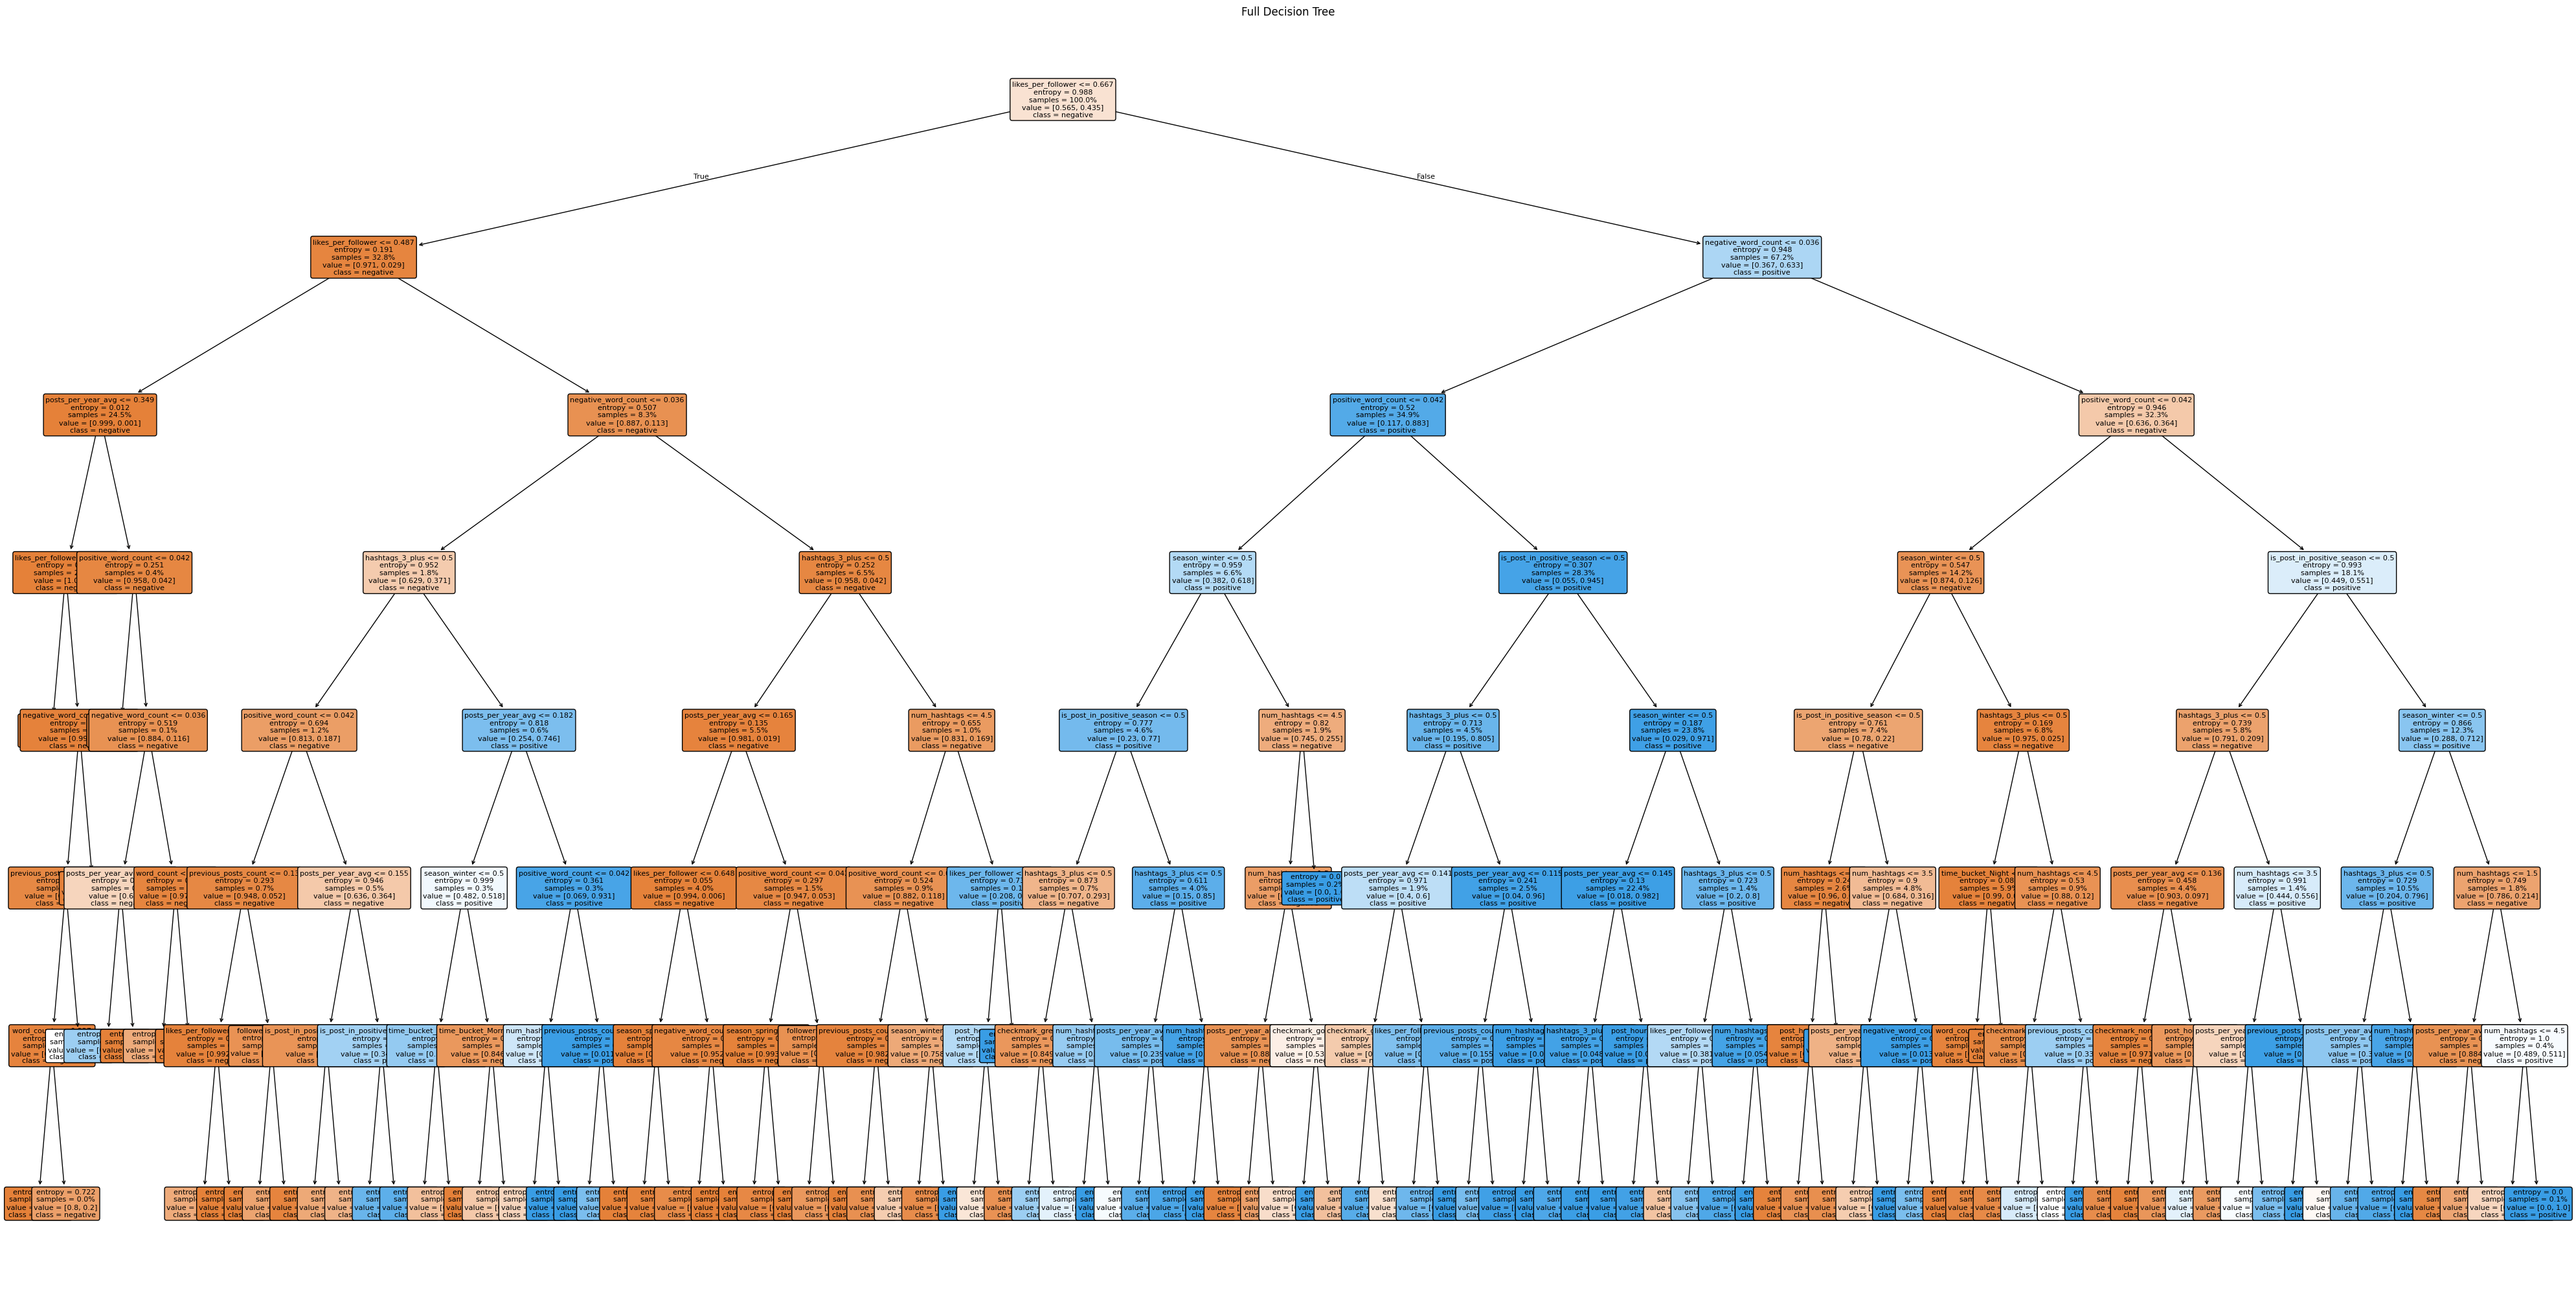

Feature Importances:
likes_per_follower: 0.417177
negative_word_count: 0.216235
positive_word_count: 0.112630
is_post_in_positive_season: 0.073137
season_winter: 0.059728
hashtags_3_plus: 0.050295
num_hashtags: 0.031437
posts_per_year_avg: 0.029564
previous_posts_count: 0.002290
post_hour: 0.002004
time_bucket_Night: 0.001051
checkmark_gold: 0.000929
followers: 0.000896
checkmark_grey: 0.000850
word_count: 0.000700
season_spring: 0.000424
checkmark_none: 0.000409
time_bucket_Morning: 0.000245
hashtags_2: 0.000000
season_summer: 0.000000
is_high_post_frequency: 0.000000
has_multiple_hashtags: 0.000000
is_younger_user: 0.000000
is_daytime_post: 0.000000
has_profile_picture: 0.000000
posts_retweets: 0.000000
is_short_post: 0.000000
age: 0.000000
checkmark_blue: 0.000000
age_<20: 0.000000


In [ ]:
# Decision Tree Grid Search and Evaluation

param_grid_dt = {
    "max_depth": np.arange(3, 31, 2),
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ['gini', 'entropy'],
    "splitter": ['best', 'random'],
    "max_features": [None, 'sqrt', 'log2']
}
df_dt_selected = df_train_full.copy()

# Decision Tree: Train/Validation Split and Label Encoding
X_dt = df_dt_selected[top_30_features].copy()
y_dt = df_dt_selected['sentiment']

le_dt = LabelEncoder()
y_dt_encoded = le_dt.fit_transform(y_dt)

X_train_dt, X_val_dt, y_train_dt, y_val_dt = train_test_split(
    X_dt, y_dt_encoded, test_size=0.2, stratify=y_dt_encoded, random_state=42
)

# Grid Search
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring="roc_auc",
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_search_dt.fit(X_train_dt, y_train_dt)
best_dt = grid_search_dt.best_estimator_
final_model_dt = best_dt

print("Best Hyperparameters:")
print(grid_search_dt.best_params_)

# Evaluate Best Model
y_val_pred_proba_dt = best_dt.predict_proba(X_val_dt)[:, 1]
val_auc_dt = roc_auc_score(y_val_dt, y_val_pred_proba_dt)
print(f"AUC on Validation Set: {val_auc_dt:.4f}")

# Plot Tree Top Layers
plt.figure(figsize=(25, 10))
plot_tree(
    best_dt,
    max_depth=3,
    filled=True,
    feature_names=X_dt.columns,
    class_names=le_dt.classes_,
    fontsize=12
)
plt.title("Top Layers of Decision Tree")
plt.show()

# Feature Importances
importances_dt = pd.Series(best_dt.feature_importances_, index=X_dt.columns)
importances_sorted_dt = importances_dt.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted_dt.values[:10], y=importances_sorted_dt.index[:10], palette="Blues_d")
plt.title("Top 10 Feature Importances – Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ROC Curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val_dt, y_val_pred_proba_dt)
plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"AUC = {val_auc_dt:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (Validation)")
plt.legend()
plt.grid()
plt.show()

#  Confusion Matrix
y_val_pred_dt = best_dt.predict(X_val_dt)
ConfusionMatrixDisplay.from_estimator(best_dt, X_val_dt, y_val_dt)
plt.title("Confusion Matrix - Decision Tree")
plt.grid(False)
plt.show()

# Final Model (Rebuild with selected hyperparameters)
dt_balanced = DecisionTreeClassifier(
    random_state=42,
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=4,
    min_samples_split=2,
    splitter='best',
    max_features=None
)
dt_balanced.fit(X_train_dt, y_train_dt)

y_train_proba_bal_dt = dt_balanced.predict_proba(X_train_dt)[:, 1]
y_val_proba_bal_dt   = dt_balanced.predict_proba(X_val_dt)[:, 1]

train_auc_bal_dt = roc_auc_score(y_train_dt, y_train_proba_bal_dt)
val_auc_bal_dt   = roc_auc_score(y_val_dt, y_val_proba_bal_dt)

print(f"AUC on Training Set (balanced tree): {train_auc_bal_dt:.4f}")
print(f"AUC on Validation Set (balanced tree): {val_auc_bal_dt:.4f}")

# Plot Full Tree
plt.figure(figsize=(40, 20), dpi=100)
plot_tree(
    best_dt,
    filled=True,
    feature_names=X_dt.columns,
    class_names=le_dt.classes_,
    fontsize=8,
    rounded=True,
    proportion=True
)
plt.title("Full Decision Tree")
plt.tight_layout()
plt.show()

# Feature Importances as Text
print("Feature Importances:")
for feat, imp in importances_sorted_dt.items():
    print(f"{feat}: {imp:.6f}")


## 1.2 ANN

### 1.2.1
Training an MLP Classifier with Default Parameters and Evaluating Performance

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report

# Create a clean copy for MLP only
df_mlp_clean = df_mlp_selected[top_30_features + ['sentiment']].dropna()
X_mlp = df_mlp_clean[top_30_features]
y_mlp = df_mlp_clean['sentiment']

#  Encode sentiment labels
le_mlp = LabelEncoder()
y_mlp_encoded = le_mlp.fit_transform(y_mlp)

#  Split into train and validation sets
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(
    X_mlp, y_mlp_encoded, test_size=0.2, stratify=y_mlp_encoded, random_state=42
)

# Train MLP with default parameters
mlp_default = MLPClassifier(random_state=42)
mlp_default.fit(X_train_mlp, y_train_mlp)


# Predict probabilities
y_train_proba_mlp = mlp_default.predict_proba(X_train_mlp)[:, 1]
y_val_proba_mlp   = mlp_default.predict_proba(X_val_mlp)[:, 1]

# AUC Scores
train_auc_mlp = roc_auc_score(y_train_mlp, y_train_proba_mlp)
val_auc_mlp   = roc_auc_score(y_val_mlp, y_val_proba_mlp)

print(f"AUC on Training Set (MLP default): {train_auc_mlp:.4f}")
print(f"AUC on Validation Set (MLP default): {val_auc_mlp:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_mlp, mlp_default.predict(X_val_mlp), target_names=le_mlp.classes_))


AUC on Training Set (MLP default): 0.9901
AUC on Validation Set (MLP default): 0.9850

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94      4277
    positive       0.93      0.92      0.93      3277

    accuracy                           0.94      7554
   macro avg       0.94      0.93      0.94      7554
weighted avg       0.94      0.94      0.94      7554



### 1.2.2
Hyperparameter Tuning for MLP using GridSearchCV with Cross-Validation

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import time

# Define the hyperparameter grid for tuning
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'learning_rate_init': [0.001, 0.0001],
    'batch_size': [32, 64, 128],
    'alpha': [0.0001, 0.001]
}

# Create MLP model for grid search
mlp_tuned = MLPClassifier(max_iter=300, random_state=42)

# Set up cross-validation strategy
cv_strategy_mlp = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Run GridSearchCV with the given parameters
grid_search_mlp = GridSearchCV(
    estimator=mlp_tuned,
    param_grid=param_grid_mlp,
    scoring='roc_auc',
    cv=cv_strategy_mlp,
    n_jobs=-1,
    verbose=10,
    refit=True,
    return_train_score=True
)

# Fit the grid search on training data
start = time.time()
grid_search_mlp.fit(X_train_mlp, y_train_mlp)
print(f"\nTotal training time: {(time.time() - start):.1f} seconds")

# Retrieve the best model
best_mlp_tuned = grid_search_mlp.best_estimator_
final_model_mlp_tuned = best_mlp_tuned

print("Best Parameters:", grid_search_mlp.best_params_)

# Evaluate performance on train and validation sets
y_train_proba_mlp_tuned = best_mlp_tuned.predict_proba(X_train_mlp)[:, 1]
y_val_proba_mlp_tuned   = best_mlp_tuned.predict_proba(X_val_mlp)[:, 1]

train_auc_mlp_tuned = roc_auc_score(y_train_mlp, y_train_proba_mlp_tuned)
val_auc_mlp_tuned   = roc_auc_score(y_val_mlp, y_val_proba_mlp_tuned)

print(f"AUC - Train: {train_auc_mlp_tuned:.4f}")
print(f"AUC - Validation: {val_auc_mlp_tuned:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

Total training time: 6083.0 seconds
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 128, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
AUC - Train: 0.9908
AUC - Validation: 0.9855


Generate Summary Table of MLP Grid Search Results for Hyperparameter Tuning

In [ ]:
import pandas as pd

# Convert GridSearchCV results into a DataFrame
results_mlp_df = pd.DataFrame(grid_search_mlp.cv_results_)

# Select relevant columns for summary table
summary_df_mlp = results_mlp_df[[
    'param_hidden_layer_sizes',
    'param_activation',
    'param_learning_rate_init',
    'param_batch_size',
    'param_alpha',
    'mean_train_score',
    'mean_test_score',
    'rank_test_score'
]].copy()

# Rename column headers for better readability
summary_df_mlp.columns = [
    'Hidden Layer Sizes', 'Activation', 'Learning Rate', 'Batch Size', 'Alpha',
    'Train AUC', 'Validation AUC', 'Rank'
]

# Sort rows by rank (best models at the top)
summary_df_mlp = summary_df_mlp.sort_values(by='Rank')

# Display the top 5 configurations
print("\nTop 5 Grid Search Results:")
print(summary_df_mlp.head())



Top 5 Grid Search Results:
   Hidden Layer Sizes Activation  Learning Rate  Batch Size   Alpha  \
22             (100,)       relu         0.0010         128  0.0010   
4               (50,)       relu         0.0010          64  0.0001   
16              (50,)       relu         0.0010          64  0.0010   
20              (50,)       relu         0.0010         128  0.0010   
3              (100,)       relu         0.0001          32  0.0001   

    Train AUC  Validation AUC  Rank  
22   0.990874        0.986075     1  
4    0.989689        0.986067     2  
16   0.989431        0.986025     3  
20   0.989447        0.985987     4  
3    0.988756        0.985879     5  


### 1.2.3

 Fine-Tuned MLP Training and Convergence Plot

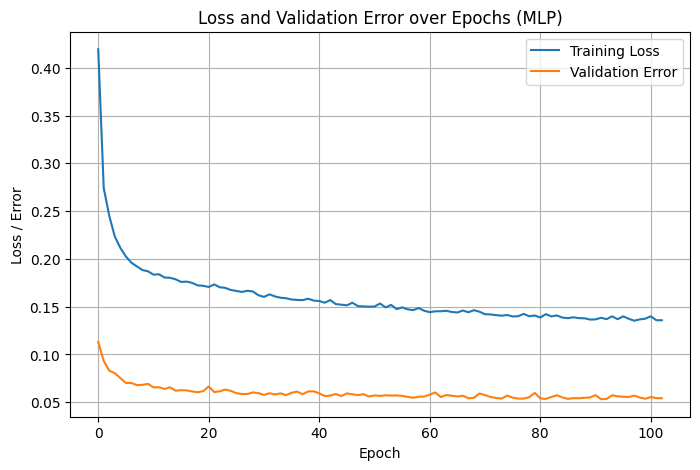

Number of epochs until convergence: 103


In [ ]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Train a new MLP model with the best hyperparameters from GridSearch
best_params_mlp = grid_search_mlp.best_params_.copy()
best_params_mlp.update({
    'early_stopping': True,
    'validation_fraction': 0.2,
    'max_iter': 300,
    'random_state': 42
})

final_model_mlp = MLPClassifier(**best_params_mlp)
final_model_mlp.fit(X_train_mlp, y_train_mlp)

# Plot training loss and validation error over epochs
plt.figure(figsize=(8, 5))
plt.plot(final_model_mlp.loss_curve_, label="Training Loss")

if hasattr(final_model_mlp, "validation_scores_"):
    val_error = [1 - score for score in final_model_mlp.validation_scores_]
    plt.plot(val_error, label="Validation Error")

plt.xlabel("Epoch")
plt.ylabel("Loss / Error")
plt.title("Loss and Validation Error over Epochs (MLP)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of epochs until convergence: {len(final_model_mlp.loss_curve_)}")


Confusion Matrix for Final MLP Model

<Figure size 600x500 with 0 Axes>

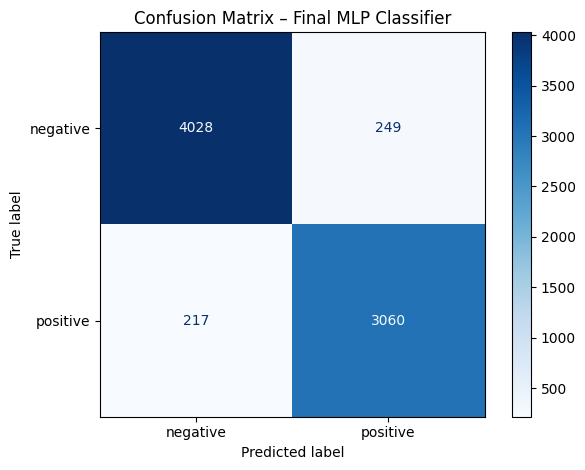

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Predict class labels on the validation set
y_val_pred_mlp = final_model_mlp.predict(X_val_mlp)

# Generate and display the confusion matrix
cm_mlp = confusion_matrix(y_val_mlp, y_val_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=le_mlp.classes_)

plt.figure(figsize=(6, 5))
disp_mlp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix – Final MLP Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()


## 1.3 SVM

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

#  Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)

#  Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)

#  Save scaler for future use
joblib.dump(scaler, 'scaler.pkl')


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

#  parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'shrinking': [True, False],
    'tol': [1e-3],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svm = SVC(kernel='linear', random_state=42)

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=10,
    refit=True  # Automatically fits the best model
)

print("Running GridSearch...")
start = time.time()
grid_svm.fit(X_train_scaled, y_train)
print(f"GridSearch completed in {time.time() - start:.1f} seconds")
print("Best parameters:", grid_svm.best_params_)


#  Use best model
final_svm = grid_svm.best_estimator_

#  Save the trained model
joblib.dump(final_svm, 'svm_model.pkl')


Running GridSearch...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
GridSearch completed in 3549.9 seconds
Best parameters: {'C': 10, 'class_weight': 'balanced', 'shrinking': False, 'tol': 0.001}


['svm_model.pkl']

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import numpy as np

# AUC Evaluation (using decision_function)
y_train_score = final_svm.decision_function(X_train_scaled)
y_val_score   = final_svm.decision_function(X_val_scaled)

print(f"\nAUC - Train: {roc_auc_score(y_train, y_train_score):.4f}")
print(f"AUC - Validation: {roc_auc_score(y_val, y_val_score):.4f}")

#  Classification report
print("\nClassification Report (Validation):")
print(classification_report(y_val, final_svm.predict(X_val_scaled), target_names=le.classes_))

#  Separating Hyperplane: Coefficients and Feature Importance
coefs = final_svm.coef_.flatten()
intercept = final_svm.intercept_[0]

feature_importance = pd.Series(np.abs(coefs), index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("\nTop 10 features by weight in separating hyperplane:")
print(feature_importance_sorted.head(10))

print("\nSeparating hyperplane (partial form):")
print(f"{intercept:.3f} + Σ(wᵢ × xᵢ)")



AUC - Train: 0.9648
AUC - Validation: 0.9634

Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      4457
    positive       0.88      0.90      0.89      3438

    accuracy                           0.90      7895
   macro avg       0.90      0.90      0.90      7895
weighted avg       0.90      0.90      0.90      7895


Top 10 features by weight in separating hyperplane:
num_hashtags                  2.221563
negative_word_count           0.920973
positive_word_count           0.753796
has_multiple_hashtags         0.651588
hashtags_3_plus               0.651588
is_post_in_positive_season    0.458569
is_high_post_frequency        0.455128
season_winter                 0.408804
likes_per_follower            0.273167
followers                     0.234732
dtype: float64

Separating hyperplane (partial form):
-0.158 + Σ(wᵢ × xᵢ)


In [ ]:
coefs     = final_svm.coef_.flatten()
intercept = final_svm.intercept_[0]
features  = X.columns

terms = [f"({w:.2f} * {feat})" for feat, w in zip(features, coefs)]

print("Linear SVM Equation:\nf(x) =")
for t in terms[:-1]:
    print("    " + t + " +")
print("    " + terms[-1])
print(f"    + ({intercept:.2f})")


Linear SVM Equation:
f(x) =
    (2.22 * num_hashtags) +
    (-0.92 * negative_word_count) +
    (-0.41 * season_winter) +
    (0.46 * is_post_in_positive_season) +
    (0.75 * positive_word_count) +
    (-0.65 * has_multiple_hashtags) +
    (-0.65 * hashtags_3_plus) +
    (0.46 * is_high_post_frequency) +
    (0.04 * posts_per_year_avg) +
    (0.06 * previous_posts_count) +
    (0.18 * season_summer) +
    (0.13 * season_spring) +
    (-0.02 * hashtags_2) +
    (0.23 * checkmark_gold) +
    (0.22 * checkmark_grey) +
    (-0.15 * checkmark_none) +
    (0.07 * has_profile_picture) +
    (-0.20 * time_bucket_Night) +
    (0.27 * likes_per_follower) +
    (-0.01 * is_daytime_post) +
    (0.06 * time_bucket_Morning) +
    (-0.13 * is_younger_user) +
    (0.05 * word_count) +
    (-0.23 * followers) +
    (-0.15 * posts_retweets) +
    (0.03 * is_short_post) +
    (-0.03 * age) +
    (-0.13 * checkmark_blue) +
    (-0.07 * post_hour) +
    (-0.11 * age_<20)
    + (-0.16)


## 1.4 Clustering

K - Means

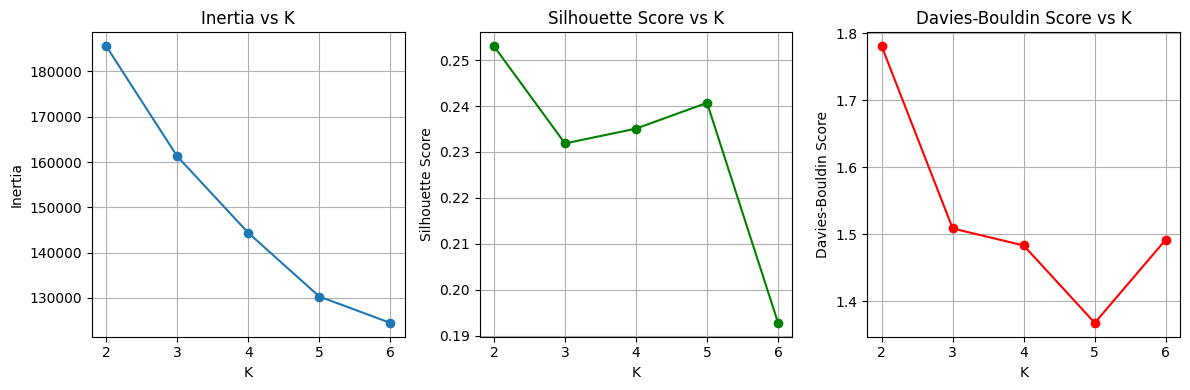

Cluster distribution by sentiment:
sentiment  negative  positive
cluster                      
0              0.81      0.19
1              0.17      0.83

Cluster-wise feature averages:
         likes_per_follower  positive_word_count  negative_word_count  \
cluster                                                                 
0                      1.85                 0.04                 0.09   
1                      4.80                 0.15                 0.03   

         word_count  posts_per_year_avg  num_hashtags  
cluster                                                
0              0.22                0.14          0.29  
1              0.31                0.26          2.59  


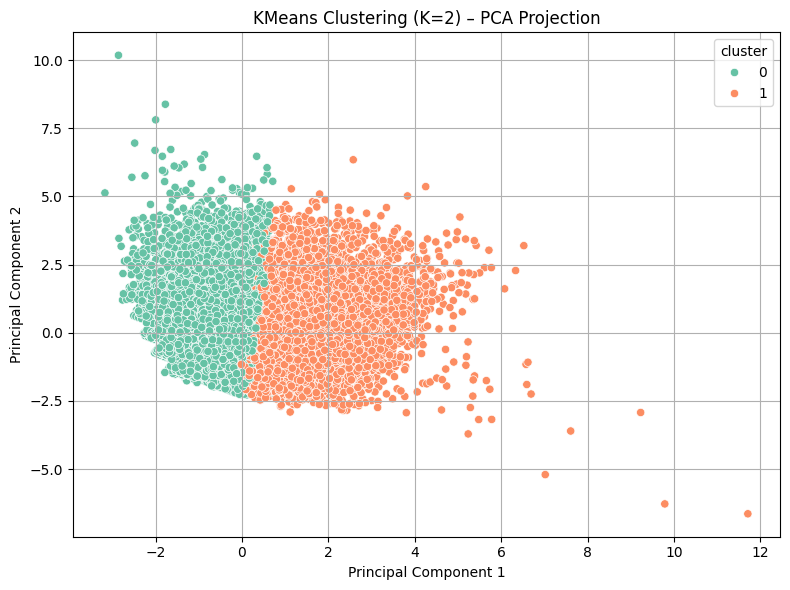

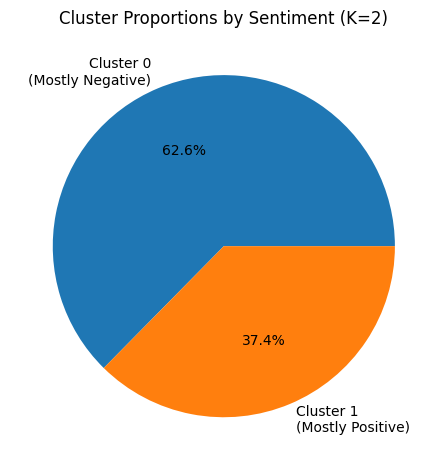

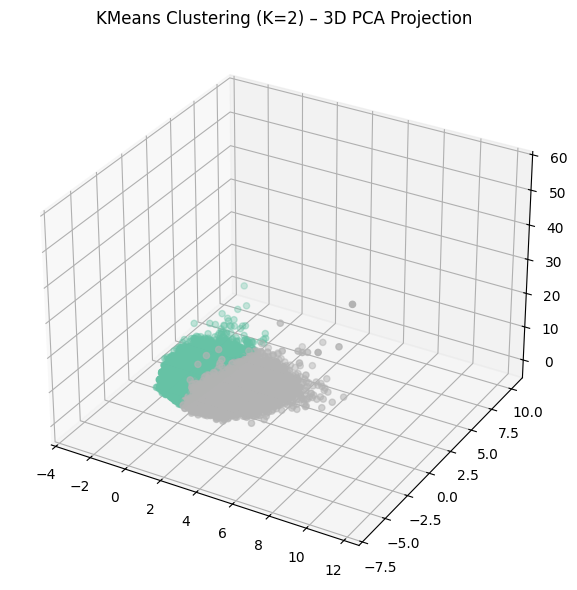

In [ ]:
df_selected = df_train_full.copy()

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection for clustering
clustering_features = [
    'likes_per_follower', 'positive_word_count',
    'negative_word_count', 'word_count',
    'posts_per_year_avg', 'num_hashtags'
]

if 'sentiment' in df_selected.columns:
    df_cluster = df_selected[clustering_features + ['sentiment']].dropna().copy()
else:
    df_cluster = df_selected[clustering_features].dropna().copy()


#  Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[clustering_features])

#  Evaluate multiple K with three metrics
K_range = range(2, 7)
results = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    db  = davies_bouldin_score(X_scaled, labels)
    inertia = model.inertia_

    results.append({
        'K': k,
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Inertia': inertia,
        'model': model,
        'labels': labels
    })

df_metrics = pd.DataFrame(results)

#  Plot metrics vs K
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(df_metrics['K'], df_metrics['Inertia'], marker='o')
plt.title('Inertia vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(df_metrics['K'], df_metrics['Silhouette'], marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(df_metrics['K'], df_metrics['Davies-Bouldin'], marker='o', color='red')
plt.title('Davies-Bouldin Score vs K')
plt.xlabel('K')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)

plt.tight_layout()
plt.show()

#  Choose best K (e.g., by silhouette)
best_k = int(df_metrics.loc[df_metrics['Silhouette'].idxmax(), 'K'])
best_entry = next(item for item in results if item['K'] == best_k)
best_model = best_entry['model']
best_labels = best_entry['labels']
df_cluster['cluster'] = best_labels

#  Evaluate cluster vs sentiment
print("Cluster distribution by sentiment:")
print(pd.crosstab(df_cluster['cluster'], df_cluster['sentiment'], normalize='index').round(2))

print("\nCluster-wise feature averages:")
print(df_cluster.groupby('cluster')[clustering_features].mean().round(2))

#  PCA 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PC1'], df_cluster['PC2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title(f"KMeans Clustering (K={best_k}) – PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

#   Cluster proportions pie chart
cluster_sentiment_map = {
    0: 'Cluster 0\n(Mostly Negative)',
    1: 'Cluster 1\n(Mostly Positive)'
}
labels = df_cluster['cluster'].map(cluster_sentiment_map).value_counts(normalize=True).index

df_cluster['cluster'].map(cluster_sentiment_map).value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%',
    ylabel='',
    title=f'Cluster Proportions by Sentiment (K={best_k})',
    labels=labels
)
plt.tight_layout()
plt.show()

#  Optional 3D PCA visualization
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=df_cluster['cluster'], cmap='Set2')
ax.set_title(f"KMeans Clustering (K={best_k}) – 3D PCA Projection")
plt.tight_layout()
plt.show()

 # 2.	Evaluation


 Training Final Models (DT,MLP,SVM) and Comparing AUC Performance

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
import joblib
from IPython.display import display

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)

# Decision Tree
final_model_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=2,
    splitter='best',
    random_state=42
)
final_model_dt.fit(X_train, y_train)
joblib.dump(final_model_dt, 'decision_tree_model.pkl')

#  MLP
final_model_mlp = MLPClassifier(
    activation='relu',
    alpha=0.001,
    batch_size=128,
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001,
    max_iter=300,
    random_state=42
)
final_model_mlp.fit(X_train_imp, y_train)
joblib.dump(final_model_mlp, 'mlp_model.pkl')

#  SVM
final_model_svm = SVC(
    C=1,
    class_weight='balanced',
    shrinking=True,
    tol=0.001,
    kernel='rbf',
    probability=False,
    random_state=42
)
final_model_svm.fit(X_train_scaled, y_train)
joblib.dump(final_model_svm, 'svm_model.pkl')


# AUC Scores
train_auc_dt = roc_auc_score(y_train, final_model_dt.predict_proba(X_train)[:, 1])
val_auc_dt   = roc_auc_score(y_val, final_model_dt.predict_proba(X_val)[:, 1])

train_auc_mlp = roc_auc_score(y_train, final_model_mlp.predict_proba(X_train_imp)[:, 1])
val_auc_mlp = roc_auc_score(y_val, final_model_mlp.predict_proba(X_val_imp)[:, 1])

train_auc_svm = roc_auc_score(y_train, final_model_svm.decision_function(X_train_scaled))
val_auc_svm   = roc_auc_score(y_val, final_model_svm.decision_function(X_val_scaled))

#  Summary Table
results = {
    'Model': ['Decision Tree', 'MLP', 'SVM'],
    'Train AUC': [train_auc_dt, train_auc_mlp, train_auc_svm],
    'Validation AUC': [val_auc_dt, val_auc_mlp, val_auc_svm]
}

summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values(by='Validation AUC', ascending=False)
display(summary_df)


,Model,Train AUC,Validation AUC
1,MLP,0.989372,0.986043
0,Decision Tree,0.980755,0.976330
2,SVM,0.981443,0.976276


### 2.1

In [ ]:
# Decision Tree
train_auc_dt = roc_auc_score(y_train, final_model_dt.predict_proba(X_train)[:, 1])
val_auc_dt   = roc_auc_score(y_val, final_model_dt.predict_proba(X_val)[:, 1])

# MLP (with imputed data)
train_auc_mlp = roc_auc_score(y_train, final_model_mlp.predict_proba(X_train_imp)[:, 1])
val_auc_mlp   = roc_auc_score(y_val, final_model_mlp.predict_proba(X_val_imp)[:, 1])

# SVM (with scaled data)
train_auc_svm = roc_auc_score(y_train, final_model_svm.decision_function(X_train_scaled))
val_auc_svm   = roc_auc_score(y_val, final_model_svm.decision_function(X_val_scaled))

# Results
results = {
    'Model': ['Decision Tree', 'MLP', 'SVM'],
    'Train AUC': [train_auc_dt, train_auc_mlp, train_auc_svm],
    'Validation AUC': [val_auc_dt, val_auc_mlp, val_auc_svm]
}

summary_df = pd.DataFrame(results).sort_values(by='Validation AUC', ascending=False)

from IPython.display import display
display(summary_df)


,Model,Train AUC,Validation AUC
1,MLP,0.989372,0.986043
0,Decision Tree,0.980755,0.976330
2,SVM,0.981443,0.976276


### 2.2

AUC for best model: 0.986
AUC for naive model: 0.500
Optimal Threshold: 0.3943


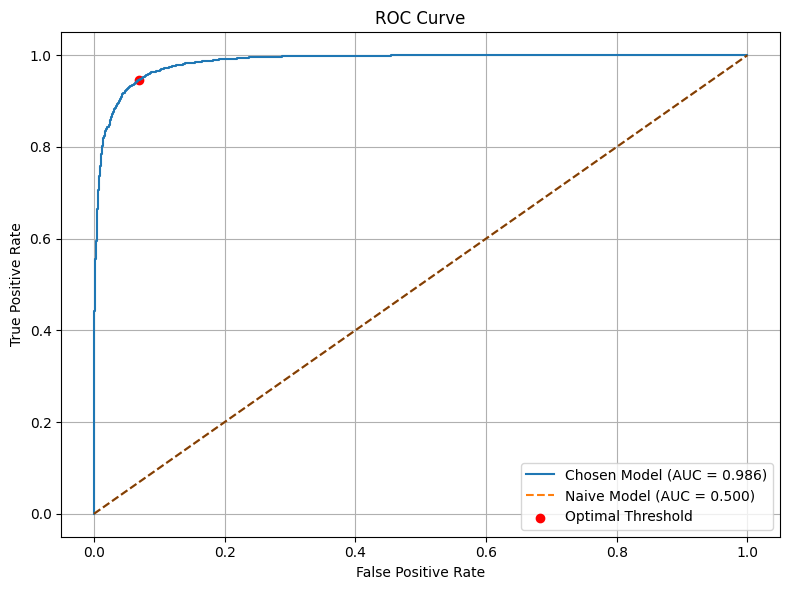

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Calculate predicted probabilities for the best model on validation data
y_val_proba_best = final_model_mlp.predict_proba(X_val_imp)[:, 1]

# Compute ROC curve and AUC for the best model
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_best)
roc_auc = auc(fpr, tpr)

# Naive classifier predicting all zeros
y_naive = np.zeros_like(y_val)
fpr_naive, tpr_naive, _ = roc_curve(y_val, y_naive)
auc_naive = auc(fpr_naive, tpr_naive)

# Print AUC scores
print(f"AUC for best model: {roc_auc:.3f}")
print(f"AUC for naive model: {auc_naive:.3f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Chosen Model (AUC = {roc_auc:.3f})')
plt.plot(fpr_naive, tpr_naive, linestyle='--', label=f'Naive Model (AUC = {auc_naive:.3f})')

# Mark the optimal threshold (max difference between TPR and FPR)
optimal_idx = np.argmax(tpr - fpr)
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Optimal Threshold')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###2.3

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

#  Feature Importance - Decision Tree (final model)
dt_importance = pd.Series(final_model_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Important Features - Decision Tree:")
print(dt_importance.head(10))

#  Feature Importance - SVM with linear kernel
# Train a new linear SVM to extract coefficients
linear_svm = SVC(kernel='linear', C=1, probability=True, class_weight='balanced', random_state=42)
linear_svm.fit(X_train_scaled, y_train)  # use scaled data

svm_importance = pd.Series(np.abs(linear_svm.coef_.flatten()), index=X.columns).sort_values(ascending=False)
print("\nTop 10 Important Features - SVM (Linear Kernel):")
print(svm_importance.head(10))

#  Overfitting Detection: Compare normal vs overfit tree
# Train a full-depth Decision Tree (likely to overfit)
dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X_train, y_train)

train_auc_full = roc_auc_score(y_train, dt_full.predict_proba(X_train)[:, 1])
val_auc_full   = roc_auc_score(y_val, dt_full.predict_proba(X_val)[:, 1])

print("\nOverfitting Check - Full Tree:")
print(f"Train AUC (Full Tree): {train_auc_full:.4f}")
print(f"Validation AUC (Full Tree): {val_auc_full:.4f}")

print("\nComparison - Final Tree vs Full Tree:")
print(f"Train AUC (Final DT): {train_auc_dt:.4f}")
print(f"Validation AUC (Final DT): {val_auc_dt:.4f}")


Top 10 Important Features - Decision Tree:
likes_per_follower            0.417177
negative_word_count           0.216235
positive_word_count           0.112630
is_post_in_positive_season    0.073137
season_winter                 0.059728
hashtags_3_plus               0.050295
num_hashtags                  0.031437
posts_per_year_avg            0.029564
previous_posts_count          0.002290
post_hour                     0.002004
dtype: float64

Top 10 Important Features - SVM (Linear Kernel):
num_hashtags                  2.196024
negative_word_count           0.920243
positive_word_count           0.752477
has_multiple_hashtags         0.641034
hashtags_3_plus               0.641034
is_post_in_positive_season    0.458755
is_high_post_frequency        0.454291
season_winter                 0.408240
likes_per_follower            0.272192
followers                     0.234330
dtype: float64

Overfitting Check - Full Tree:
Train AUC (Full Tree): 0.9998
Validation AUC (Full Tree): 0.9003


# 3.	Improvements

 Data Preprocessing Improvement: TF-IDF Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

#  Ensure df_train_full includes both 'text' and top_30_features
df_text = df_train_full.copy()

#  Remove rows with missing text just in case
df_text = df_text[df_text['text'].notna()].copy()

#  Apply TF-IDF on the 'text' column
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_text['text'])

#  Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df_text.index)

#  Concatenate with top features
X_base = df_text[top_30_features].reset_index(drop=True)
X_tfidf = pd.concat([X_base, tfidf_df.reset_index(drop=True)], axis=1)

#  Target variable
y_tfidf = df_text['sentiment'].reset_index(drop=True)


Model Improvement: MLP with Adaptive Learning Rate

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
import pandas as pd

#   Impute NaNs in TF-IDF + top features
imputer = SimpleImputer(strategy='median')
X_tfidf_imputed = pd.DataFrame(
    imputer.fit_transform(X_tfidf),
    columns=X_tfidf.columns,
    index=X_tfidf.index
)

#  Encode target labels
le = LabelEncoder()
y_encoded_tfidf = le.fit_transform(y_tfidf)

#  Train/test split
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(
    X_tfidf_imputed, y_encoded_tfidf, test_size=0.2, stratify=y_encoded_tfidf, random_state=42
)

#  Train MLP with adaptive learning rate
mlp_adaptive = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
mlp_adaptive.fit(X_train_tfidf, y_train_tfidf)

# Evaluate AUC
y_train_proba_adaptive = mlp_adaptive.predict_proba(X_train_tfidf)[:, 1]
y_val_proba_adaptive   = mlp_adaptive.predict_proba(X_val_tfidf)[:, 1]

train_auc_adaptive = roc_auc_score(y_train_tfidf, y_train_proba_adaptive)
val_auc_adaptive   = roc_auc_score(y_val_tfidf, y_val_proba_adaptive)

print(f"AUC - Train (adaptive): {train_auc_adaptive:.4f}")
print(f"AUC - Validation (adaptive): {val_auc_adaptive:.4f}")


AUC - Train (adaptive): 0.9888
AUC - Validation (adaptive): 0.9840


# 4. Test

In [ ]:
import pandas as pd
import numpy as np
import requests
import joblib
import urllib.request
from sklearn.preprocessing import LabelEncoder

# --- Load test data ---
test_csv_url = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/test.csv"
df_test_raw = pd.read_csv(test_csv_url)

# --- Load sentiment word lists ---
url_pos = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/positive-words.txt"
url_neg = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/negative-words.txt"

positive_words = set([
    line.strip() for line in requests.get(url_pos).text.splitlines()
    if line.strip() and not line.startswith(';')
])
negative_words = set([
    line.strip() for line in requests.get(url_neg).text.splitlines()
    if line.strip() and not line.startswith(';')
])

# --- Load trained scaler ---
scaler_url = "https://raw.githubusercontent.com/SapirGabay/ML_Project_Part1/main/scaler.pkl"
trained_scaler = joblib.load(urllib.request.urlopen(scaler_url))

# --- Apply preprocessing pipeline (same as for train) ---
X_test = prepare_test_data_only(df_test_raw, positive_words, negative_words, trained_scaler)

# --- Keep only the features used for training ---
top_30_features = [
    'num_hashtags', 'negative_word_count', 'season_winter', 'is_post_in_positive_season',
    'positive_word_count', 'has_multiple_hashtags', 'hashtags_3_plus', 'is_high_post_frequency',
    'posts_per_year_avg', 'previous_posts_count', 'season_summer', 'season_spring',
    'hashtags_2', 'checkmark_gold', 'checkmark_grey', 'checkmark_none',
    'has_profile_picture', 'time_bucket_Night', 'likes_per_follower', 'is_daytime_post',
    'time_bucket_Morning', 'is_younger_user', 'word_count', 'followers',
    'posts_retweets', 'is_short_post', 'age', 'checkmark_blue',
    'post_hour', 'age_<20'
]

X_test_input = X_test[top_30_features].copy()

# --- Load trained model (MLP) ---
mlp_model = joblib.load("mlp_model.pkl")

# --- Predict labels ---
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_test_input_imputed = imputer.fit_transform(X_test_input)

pred_labels = mlp_model.predict(X_test_input_imputed)


# --- Convert labels back to 'positive' / 'negative' if needed ---
le = LabelEncoder()
le.fit(["negative", "positive"])
pred_sentiments = le.inverse_transform(pred_labels)

# --- Create output DataFrame ---
submission_df = pd.DataFrame({
    "sentiment": pred_sentiments,
    "id": X_test["id"]
})

# --- Save to CSV with correct format ---
submission_df.to_csv("group19.csv", index=False)
print("Saved group19.csv successfully.")


<ipython-input-1-2382245564>:40: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_clean['birthday'] = pd.to_datetime(df_clean['birthday'], errors='coerce', dayfirst=True)
<ipython-input-1-2382245564>:42: UserWarning: Parsing dates in %m/%d/%Y %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_clean['post_datetime'] = pd.to_datetime(df_clean['post_datetime'], errors='coerce', dayfirst=True)


Final columns: ['num_hashtags', 'negative_word_count', 'season_winter', 'is_post_in_positive_season', 'positive_word_count', 'has_multiple_hashtags', 'hashtags_3_plus', 'is_high_post_frequency', 'posts_per_year_avg', 'previous_posts_count', 'season_summer', 'season_spring', 'hashtags_2', 'checkmark_gold', 'checkmark_grey', 'checkmark_none', 'has_profile_picture', 'time_bucket_Night', 'likes_per_follower', 'is_daytime_post', 'time_bucket_Morning', 'is_younger_user', 'word_count', 'followers', 'posts_retweets', 'is_short_post', 'age', 'checkmark_blue', 'post_hour', 'age_<20', 'id', 'text']
Missing values: 74
Saved group19.csv successfully.


In [ ]:
from google.colab import files
files.download("group19.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>